In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_1353265/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "Frax"
SPLITS_FREQ = "5d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2022-05-26"


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 359 non-null    object        
 1   author             359 non-null    object        
 2   date               359 non-null    datetime64[us]
 3   start              359 non-null    datetime64[us]
 4   end                359 non-null    datetime64[us]
 5   platform_proposal  359 non-null    object        
dtypes: datetime64[us](3), object(3)
memory usage: 17.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10184 entries, 0 to 10183
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        10184 non-null  object        
 1   proposal  10184 non-null  object        
 2   voter     10184 non-null  object        
 3   date      10184 non-null  datetime64[us]
dtypes:

## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['fold'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('fold')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
paths.save_folds_info(sdf_all, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Frax/baseline/folds-info_5d_normalize.parquet
fold
2023-05-31     9484
2023-06-05     9566
2023-06-10     9608
2023-06-15     9695
2023-06-20     9808
2023-06-25     9860
2023-06-30     9984
2023-07-05    10062
2023-07-10    10087
2023-07-15    10140
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
fold,,,,,,,,,
2023-W22,0,0,0,nan,nan,0,0,nan,nan
2023-W23,4,82,33,20.50,2.48,24,12,6.00,2.00
2023-W23,2,18,10,9.00,1.80,24,15,12.00,1.60
2023-W24,9,63,11,7.00,5.73,67,14,7.44,4.79
2023-W25,4,43,15,10.75,2.87,37,26,9.25,1.42
2023-W25,5,13,13,2.60,1.00,108,38,21.60,2.84
2023-W26,2,14,12,7.00,1.17,40,31,20.00,1.29
2023-W27,1,34,34,34.00,1.00,1,1,1.00,1.00
2023-W28,1,24,24,24.00,1.00,5,5,5.00,1.00


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
fold &  &  &  &  &  &  &  &  &  \\
2023-W22 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W23 & 4 & 82 & 33 & 20.50 & 2.48 & 24 & 12 & 6.00 & 2.00 \\
2023-W23 & 2 & 18 & 10 & 9.00 & 1.80 & 24 & 15 & 12.00 & 1.60 \\
2023-W24 & 9 & 63 & 11 & 7.00 & 5.73 & 67 & 14 & 7.44 & 4.79 \\
2023-W25 & 4 & 43 & 15 & 10.75 & 2.87 & 37 & 26 & 9.25 & 1.42 \\
2023-W25 & 5 & 13 & 13 & 2.60 & 1.00 & 108 & 38 & 21.60 & 2.84 \\
2023-W26 & 2 & 14 & 12 & 7.00 & 1.17 & 40 & 31 & 20.00 & 1.29 \\
2023-W27 & 1 & 34 & 34 & 34.00 & 1.00 & 1 & 1 & 1.00 & 1.00 \\
2023-W28 & 1 & 24 & 24 & 24.00 & 1.00 & 5 & 5 & 5.00 & 1.00 \\
2023-W28 & 5 & 48 & 17 & 9.60 & 2.82 & 39 & 20 & 7.80 & 1.95 \\
\end{tabular}

## Running openpop baseline

In [9]:
WARNING_AT_LEAST_OPEN = 5

folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
ok_in_a_row = best_in_a_row = 0
max_ok_in_a_row = (-1, folds[-1].end)
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):   
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i} ({t}), all ok since {ok_in_a_row} folds ago", file=sys.stderr)
        ok_in_a_row = best_in_a_row = 0
    elif len(open_proposals) < WARNING_AT_LEAST_OPEN:
        print(f"Warning, test fold {i} ({t}) with less than {WARNING_AT_LEAST_OPEN} open proposals ({len(open_proposals)}). all ok since {best_in_a_row} folds ago", file=sys.stderr)
        best_in_a_row = 0

    mdict = {'fold': t}
    pdict = {'fold': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)
    ok_in_a_row += 1
    best_in_a_row += 1

    if ok_in_a_row > max_ok_in_a_row[0]:
        max_ok_in_a_row = (ok_in_a_row, t)

paths.save_dao_datum(ORG_NAME, 'max_ok_folds', str(max_ok_in_a_row[0]))
paths.save_dao_datum(ORG_NAME, 'max_ok_folds_date', str(max_ok_in_a_row[1]))
if max_ok_in_a_row[0] == -1:
    print("All ok :>")
else:
    print("Max ok in a row:", max_ok_in_a_row)

  0%|          | 0/178 [00:00<?, ?it/s]

Warning, empty test fold 0 (2021-02-10 00:00:00), all ok since 0 folds ago
Warning, empty test fold 1 (2021-02-15 00:00:00), all ok since 1 folds ago


Warning, empty test fold 2 (2021-02-20 00:00:00), all ok since 1 folds ago
Warning, empty test fold 3 (2021-02-25 00:00:00), all ok since 1 folds ago


Warning, empty test fold 4 (2021-03-02 00:00:00), all ok since 1 folds ago
Warning, empty test fold 5 (2021-03-07 00:00:00), all ok since 1 folds ago


Warning, empty test fold 6 (2021-03-12 00:00:00), all ok since 1 folds ago
Warning, empty test fold 7 (2021-03-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 8 (2021-03-22 00:00:00), all ok since 1 folds ago
Warning, empty test fold 9 (2021-03-27 00:00:00), all ok since 1 folds ago


Warning, empty test fold 10 (2021-04-01 00:00:00), all ok since 1 folds ago
Warning, empty test fold 11 (2021-04-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 12 (2021-04-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 13 (2021-04-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 14 (2021-04-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 15 (2021-04-26 00:00:00), all ok since 1 folds ago


Warning, empty test fold 16 (2021-05-01 00:00:00), all ok since 1 folds ago
Warning, empty test fold 17 (2021-05-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 18 (2021-05-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 19 (2021-05-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 20 (2021-05-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 21 (2021-05-26 00:00:00), all ok since 1 folds ago


Warning, empty test fold 22 (2021-05-31 00:00:00), all ok since 1 folds ago
Warning, test fold 23 (2021-06-05 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 24 (2021-06-10 00:00:00), all ok since 2 folds ago
Warning, empty test fold 25 (2021-06-15 00:00:00), all ok since 1 folds ago


Warning, empty test fold 26 (2021-06-20 00:00:00), all ok since 1 folds ago
Warning, empty test fold 27 (2021-06-25 00:00:00), all ok since 1 folds ago


Warning, empty test fold 28 (2021-06-30 00:00:00), all ok since 1 folds ago
Warning, test fold 29 (2021-07-05 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 30 (2021-07-10 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 31 (2021-07-15 00:00:00), all ok since 3 folds ago
Warning, empty test fold 32 (2021-07-20 00:00:00), all ok since 1 folds ago


Warning, empty test fold 33 (2021-07-25 00:00:00), all ok since 1 folds ago
Warning, empty test fold 34 (2021-07-30 00:00:00), all ok since 1 folds ago


Warning, empty test fold 35 (2021-08-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 36 (2021-08-09 00:00:00), all ok since 1 folds ago


Warning, test fold 37 (2021-08-14 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 38 (2021-08-19 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 39 (2021-08-24 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 40 (2021-08-29 00:00:00), all ok since 4 folds ago
Warning, empty test fold 41 (2021-09-03 00:00:00), all ok since 1 folds ago


Warning, test fold 42 (2021-09-08 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 43 (2021-09-13 00:00:00), all ok since 2 folds ago
Warning, test fold 44 (2021-09-18 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 45 (2021-09-23 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 46 (2021-09-28 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 47 (2021-10-03 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 48 (2021-10-08 00:00:00), all ok since 5 folds ago
Warning, test fold 49 (2021-10-13 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 50 (2021-10-18 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 51 (2021-10-23 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 52 (2021-10-28 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 53 (2021-11-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 54 (2021-11-07 00:00:00), all ok since 6 folds ago
Warning, test fold 55 (2021-11-12 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 56 (2021-11-17 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 57 (2021-11-22 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 58 (2021-11-27 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 59 (2021-12-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 60 (2021-12-07 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 61 (2021-12-12 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 62 (2021-12-17 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 64 (2021-12-27 00:00:00) with less than 5 open proposals (3). all ok since 2 folds ago


Warning, test fold 66 (2022-01-06 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago


Warning, test fold 67 (2022-01-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 68 (2022-01-16 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 69 (2022-01-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 70 (2022-01-26 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 71 (2022-01-31 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 72 (2022-02-05 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 73 (2022-02-10 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 74 (2022-02-15 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 75 (2022-02-20 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 76 (2022-02-25 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 77 (2022-03-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 78 (2022-03-07 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 79 (2022-03-12 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 80 (2022-03-17 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 81 (2022-03-22 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 82 (2022-03-27 00:00:00), all ok since 28 folds ago
Warning, test fold 83 (2022-04-01 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 84 (2022-04-06 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 85 (2022-04-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 87 (2022-04-21 00:00:00) with less than 5 open proposals (1). all ok since 2 folds ago


Warning, test fold 88 (2022-04-26 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 89 (2022-05-01 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 90 (2022-05-06 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 91 (2022-05-11 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 92 (2022-05-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 93 (2022-05-21 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 94 (2022-05-26 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 95 (2022-05-31 00:00:00), all ok since 13 folds ago
Warning, test fold 96 (2022-06-05 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 97 (2022-06-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 99 (2022-06-20 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago


Warning, test fold 100 (2022-06-25 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 101 (2022-06-30 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 102 (2022-07-05 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 103 (2022-07-10 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 104 (2022-07-15 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 105 (2022-07-20 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 106 (2022-07-25 00:00:00), all ok since 11 folds ago
Warning, empty test fold 107 (2022-07-30 00:00:00), all ok since 1 folds ago


Warning, empty test fold 108 (2022-08-04 00:00:00), all ok since 1 folds ago
Warning, test fold 109 (2022-08-09 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 110 (2022-08-14 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 111 (2022-08-19 00:00:00), all ok since 3 folds ago
Warning, empty test fold 112 (2022-08-24 00:00:00), all ok since 1 folds ago


Warning, test fold 113 (2022-08-29 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 114 (2022-09-03 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 115 (2022-09-08 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 116 (2022-09-13 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 117 (2022-09-18 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 118 (2022-09-23 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 119 (2022-09-28 00:00:00), all ok since 7 folds ago
Warning, empty test fold 120 (2022-10-03 00:00:00), all ok since 1 folds ago


Warning, empty test fold 121 (2022-10-08 00:00:00), all ok since 1 folds ago


Warning, empty test fold 123 (2022-10-18 00:00:00), all ok since 2 folds ago
Warning, empty test fold 124 (2022-10-23 00:00:00), all ok since 1 folds ago


Warning, test fold 125 (2022-10-28 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 126 (2022-11-02 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 127 (2022-11-07 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 128 (2022-11-12 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 130 (2022-11-22 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago


Warning, empty test fold 132 (2022-12-02 00:00:00), all ok since 8 folds ago
Warning, test fold 133 (2022-12-07 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 134 (2022-12-12 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 135 (2022-12-17 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 136 (2022-12-22 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 137 (2022-12-27 00:00:00), all ok since 5 folds ago
Warning, empty test fold 138 (2023-01-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 139 (2023-01-06 00:00:00), all ok since 1 folds ago
Warning, test fold 140 (2023-01-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 145 (2023-02-05 00:00:00), all ok since 6 folds ago
Warning, test fold 146 (2023-02-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 147 (2023-02-15 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 148 (2023-02-20 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 150 (2023-03-02 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago


Warning, empty test fold 151 (2023-03-07 00:00:00), all ok since 6 folds ago
Warning, test fold 152 (2023-03-12 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 153 (2023-03-17 00:00:00), all ok since 2 folds ago
Warning, test fold 154 (2023-03-22 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 155 (2023-03-27 00:00:00), all ok since 2 folds ago


Warning, test fold 158 (2023-04-11 00:00:00) with less than 5 open proposals (3). all ok since 3 folds ago


Warning, test fold 159 (2023-04-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 160 (2023-04-21 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 161 (2023-04-26 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 162 (2023-05-01 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 163 (2023-05-06 00:00:00), all ok since 8 folds ago
Warning, test fold 164 (2023-05-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 165 (2023-05-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 166 (2023-05-21 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 167 (2023-05-26 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 168 (2023-05-31 00:00:00), all ok since 5 folds ago
Warning, test fold 169 (2023-06-05 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 170 (2023-06-10 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 172 (2023-06-20 00:00:00) with less than 5 open proposals (4). all ok since 2 folds ago


Warning, test fold 174 (2023-06-30 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago


Warning, test fold 175 (2023-07-05 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 176 (2023-07-10 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Max ok in a row: (28, Timestamp('2022-03-22 00:00:00'))


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("fold")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Frax/baseline/openpop_5d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,...,178.000000,178.000000,178.000000,178.000000,177.000000,177.000000,177.000000,177.000000,177.000000,178.000000
mean,0.477495,0.255496,0.171549,0.090455,0.060303,0.009045,0.474854,0.533077,0.544096,0.549708,...,0.611433,0.611433,0.611433,0.496773,0.576789,0.589157,0.592557,0.592557,0.592557,0.103958
std,0.424624,0.221060,0.165226,0.092911,0.061941,0.009291,0.425705,0.441525,0.444032,0.445114,...,0.482277,0.482277,0.482277,0.430742,0.460204,0.463224,0.464063,0.464063,0.464063,0.026010
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067863
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070517
50%,0.450725,0.333333,0.200000,0.100000,0.066667,0.010000,0.447619,0.751493,0.766570,0.781841,...,1.000000,1.000000,1.000000,0.544643,0.823529,0.907407,0.916667,0.916667,0.916667,0.120529
75%,1.000000,0.394097,0.253574,0.126787,0.084525,0.012679,1.000000,0.994874,0.994874,0.994874,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.124263
max,1.000000,0.794872,0.800000,0.478571,0.319048,0.047857,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.135914


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("fold")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Frax/baseline/perfect_5d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,...,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,0.657303,0.295772,0.188207,0.096125,0.064083,0.009612,0.657303,0.657303,0.657303,0.657303,...,0.657303,0.657303,0.657303,0.561666,0.643938,0.654777,0.657303,0.657303,0.657303,0.111046
std,0.475950,0.250538,0.174431,0.093124,0.062082,0.009312,0.475950,0.475950,0.475950,0.475950,...,0.475950,0.475950,0.475950,0.435156,0.468609,0.474389,0.475950,0.475950,0.475950,0.030424
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071749
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073715
50%,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.736111,1.000000,1.000000,1.000000,1.000000,1.000000,0.127424
75%,1.000000,0.429724,0.257834,0.128917,0.085945,0.012892,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.129767
max,1.000000,1.000000,0.800000,0.478571,0.319048,0.047857,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.303023


## Plotting some graphs

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,178,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,...,178.000000,178.000000,177.000000,177.000000,177.000000,177.000000,177.000000,178.000000,0.0,0.0
mean,2022-04-28 12:00:00,0.477495,0.255496,0.171549,0.090455,0.060303,0.009045,0.474854,0.533077,0.544096,...,0.611433,0.496773,0.576789,0.589157,0.592557,0.592557,0.592557,0.103958,NaN,NaN
min,2021-02-10 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067863,NaN,NaN
25%,2021-09-19 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070517,NaN,NaN
50%,2022-04-28 12:00:00,0.450725,0.333333,0.200000,0.100000,0.066667,0.010000,0.447619,0.751493,0.766570,...,1.000000,0.544643,0.823529,0.907407,0.916667,0.916667,0.916667,0.120529,NaN,NaN
75%,2022-12-05 18:00:00,1.000000,0.394097,0.253574,0.126787,0.084525,0.012679,1.000000,0.994874,0.994874,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.124263,NaN,NaN
max,2023-07-15 00:00:00,1.000000,0.794872,0.800000,0.478571,0.319048,0.047857,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.135914,NaN,NaN
std,NaN,0.424624,0.221060,0.165226,0.092911,0.061941,0.009291,0.425705,0.441525,0.444032,...,0.482277,0.430742,0.460204,0.463224,0.464063,0.464063,0.464063,0.026010,NaN,NaN


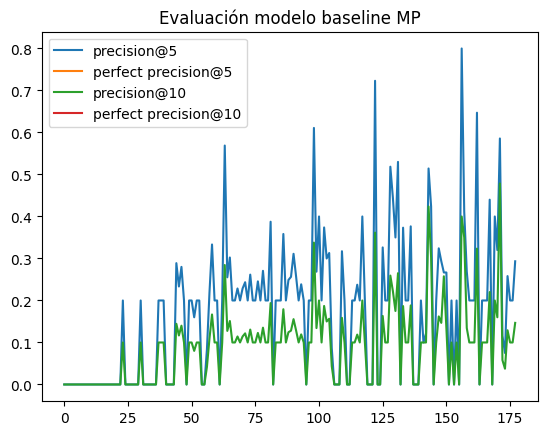

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,0.0
mean,2023-06-22 12:00:00,0.548305,0.332904,0.244790,0.140967,0.093978,0.014097,0.531466,0.567500,0.586661,...,0.683535,0.528713,0.672639,0.700642,0.715754,0.715754,0.715754,0.120818,NaN,NaN
min,2023-05-31 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070783,NaN,NaN
25%,2023-06-11 06:00:00,0.254167,0.228070,0.136842,0.068421,0.045614,0.006842,0.212500,0.198676,0.189557,...,0.252909,0.275248,0.424554,0.560731,0.585863,0.585863,0.585863,0.123050,NaN,NaN
50%,2023-06-22 12:00:00,0.542339,0.333333,0.229032,0.114516,0.076344,0.011452,0.512733,0.626555,0.720829,...,1.000000,0.501229,0.745536,0.745536,0.770833,0.770833,0.770833,0.125289,NaN,NaN
75%,2023-07-03 18:00:00,0.864286,0.482527,0.313333,0.156667,0.104444,0.015667,0.864286,0.936306,0.936306,...,1.000000,0.763258,1.000000,1.000000,1.000000,1.000000,1.000000,0.130680,NaN,NaN
max,2023-07-15 00:00:00,1.000000,0.547619,0.585714,0.478571,0.319048,0.047857,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.131144,NaN,NaN
std,NaN,0.377452,0.181742,0.169284,0.132846,0.088564,0.013285,0.391638,0.392683,0.399306,...,0.431043,0.342903,0.350434,0.334906,0.334706,0.334706,0.334706,0.018191,NaN,NaN
